In [1]:
# 导入包
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 画图
import seaborn as sns
%matplotlib inline
# 在notebook中展示图

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# 图的中文显示有问题

In [2]:
# 导入包
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 画图
import seaborn as sns
%matplotlib inline 
# 在notebook中展示图

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# 图的中文显示有问题

# 11.1场景介绍

在金融领域中，对某一指标的预测，是绕不开的业务问题，比如对房价的预测、贷款额度的预测。
被预测的指标可以称为被解释变量，影响预测指标的称为解释变量。
对未来的把握，可以帮助从业者提前预警甚至规避风险，也可以通过掌握事物发展的内在逻辑，有条件地控制强化或减弱解释变量推动被解释变量的发展。
在本章中，将以产品销售额度的预测为案例来进行说明，
使用的广告数据集（https://www.kaggle.com/ashydv/advertising-dataset）
给出了在TV,Radio,Newspaper投放不等的广告带来的销售额。
在预测时，业务问题关心的不仅是数值本身，比如产品的销售额是否偏离了预期，未来的增长或减少比较对现阶段业务状况是否是一个危险的信号，
业务更关心导致销售额的数值发生变化的的内在原因，找到这些原因，也就是找到了提升销售额度的方法。通过该产品销售额度预测案例，找出较强影响销售额的广告渠道，
这样可以让商业广告投放更为精准有效，转化为可观的商业价值，带来销售额的增长。

# 11.2数据准备

一、读取数据

广告数据集包含广告在电视、广播和报纸上的支出以及相应的销售额。该数据集共200条，含4个连续变量。

In [3]:
# 导入包
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv("./dataset/advertising.csv")
df.head(3)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0


In [4]:
# 按TV升序排列，对画图有利
#　df.sort_values(by='TV' , inplace=True, ascending=True) 

In [5]:
# 查看数据维度
df.shape

(200, 4)

数据类型都为连续型取值

In [6]:
# 查看数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [7]:
# 统计数据
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [8]:
# 统计列缺失值
df.isnull().sum(axis=0)

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [9]:
df[df.isnull().sum(axis=1)>0].isnull().sum(axis=1)

Series([], dtype: int64)

各变量不存在缺失值

二、探索相关性

相关性是指解释变量和被解释变量之间存在某种相关关系，才可能通过控制解释变量影响被解释变量。一般假设特征与目标指标之间存在线性关系，这也是线性回归的前提条件。
线性回归关注线性关系，这可以通过绘制解释变量和被解释变量之间的散点图来验证。

可以看出，电视广告投放与销售额之间存在明显的线性关系，且为正相关，即随着电视广告投放的增加，销售额也会增加；而广播、报纸与销售额之间的线性关系难以观察到，但这并不意味着他们对销售额没有影响，可以通过构建模型来进一步探索。

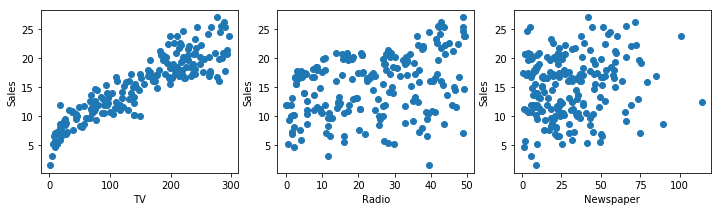

In [10]:
# 绘制特征变量和
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,3))
ax1=fig.add_subplot(131)
ax1.set_xlabel('TV')
ax1.set_ylabel('Sales')
ax1.scatter(df['TV'].values,df['Sales'].values)
ax2=fig.add_subplot(132)
ax2.set_xlabel('Radio')
ax2.set_ylabel('Sales')
ax2.scatter(df['Radio'].values,df['Sales'].values)
ax3=fig.add_subplot(133)
ax3.set_xlabel('Newspaper')
ax3.set_ylabel('Sales')
ax3.scatter(df['Newspaper'].values,df['Sales'].values)

三、探索多重共线性

多重共线性是指线性回归模型中的解释变量之间由于存在确定的相关关系或高度相关关系而使模型估计失真或难以估计准确。
一般来说，由于经济数据普遍存在内在联系，如果解释变量选取得不合适，模型设计不当，容易导致设计矩阵中解释变量间存在普遍的相关关系。比如变量X1与X2线性相关，当X1和X2一起作为Y的解释变量时，就可能会出现模型回归不显著的情况，甚至将重要的解释变量变得不重要，参数估计值的方差也随之增大。这是因为，在回归方程中，当其他特征保持不变时，其中某个特征与目标指标的关系可以用回归系数来解释，回归系数的正负代表了解释变量与被解释变量的正负相关性，取值的大小也代表了相关程度。但当存在多重共线性，特征和特征之间相关，一个特征的变化会反过来改变另一个特征，模型就很难独立地估计每个特征与目标之间的关系。

如果出现多重共线性，可以通过构建新的特征集来改善，比如放弃某个特征，或者将两个高度相关的特征结合起来形成一个新特征。

同样地通过特征之间的散点图可以查看相关性，但由于特征之间两两组合太多，可以通过相关矩阵或者热力图来快速地识别高度相关的特征。从相关矩阵和热力图都可以看出，每个特征之间的相关系数均低于0.4。因此，这些特征之间并不是高度相关的。



In [11]:
df.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


The above pair plot shows no significant relationship between the features.

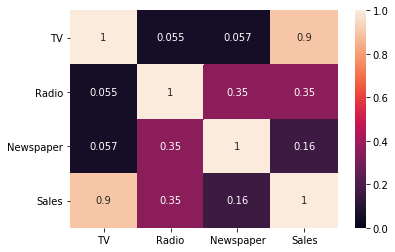

In [12]:
# 导入画图包
import matplotlib.pyplot as plt
%matplotlib inline 
# 在notebook中展示图
import seaborn as sns
# 画热力图
sns.heatmap(df.corr(),vmin=0,vmax=1,annot = True)

四、划分数据集

划分80%的数据用于训练，20%用于测试，因此数据集被划分为含160条数据的训练集和40条数据的测试集。

In [13]:
# 划分数据集
from sklearn.model_selection import train_test_split
X=df[['TV','Radio','Newspaper']].values        
y=df['Sales'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)#数据按%80，%20划分

# 11.3建模

以一元线性回归为例，对前文补图

In [14]:
X_train_one, X_test_one=X_train[:,0].reshape(-1,1), X_test[:,0].reshape(-1,1)

In [15]:
# 提取第一列TV作为解释变量
X_train_one, X_test_one=X_train[:,0].reshape(-1,1), X_test[:,0].reshape(-1,1)

from sklearn.linear_model import LinearRegression
# 创建模型
model_one = LinearRegression()
# 拟合
model_one.fit(X_train_one,y_train)
# 预测
y_train_hat_one=model_one.predict(X_train_one)


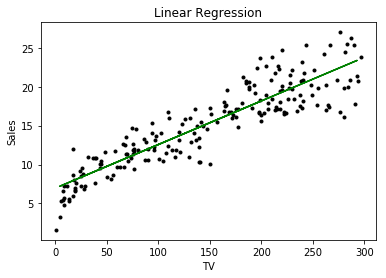

In [16]:
# 一元线性回归图
plt.plot(df[['TV']].values,df['Sales'].values, 'k.')
plt.title('Linear Regression')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.plot(X_train_one,y_train_hat_one, 'g-')
plt.show()

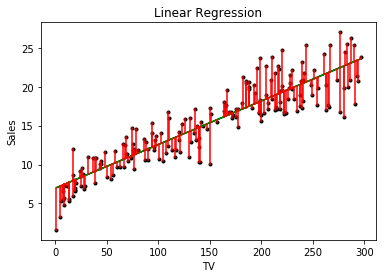

In [17]:
# 做前文插图
plt.plot(df[['TV']].values,df['Sales'].values, 'k.')
plt.title('Linear Regression')
plt.xlabel('TV')
plt.ylabel('Sales')
# model = LinearRegression()
# model.fit(df[['TV']].values,df['Sales'].values)
plt.plot(df[['TV']].values, model_one.predict(df[['TV']].values), 'g-')
# 残差预测值
for i, x in enumerate(df[['TV']].values):#  enumerate 函数可以把一个 list 变成索引-元素对
    plt.plot([x,x],
             [df['Sales'].values[i],model_one.predict(df[['TV']].values)[i]],'r-')
plt.show()

In [18]:
# 计算残差平方和
print('残差平方和:{:.2f}'.format(np.mean((y_train_hat_one - y_train) ** 2)))
# 计算判决系数
print('判决系数:{:.2f}'.format(model_one.score(X_train_one, y_train)))

残差平方和:5.07
判决系数:0.82


In [19]:
# 建模
model_two=LinearRegression()
# 拟合
model_two.fit(X_train[:,:2], y_train)
# 预测
y_train_hat_two=model_two.predict(X_train[:,:2])

# 计算残差平方和
print('残差平方和:{:.2f}'.format(np.mean((y_train_hat_two - y_train) ** 2)))
# 计算R方
print('判决系数:{:.2f}'.format(model_two.score(X_train[:,:2], y_train)))

残差平方和:2.41
判决系数:0.91


In [20]:
# 后面是多元回归

使用 sklearn.linear_model中LinearRegression函数即可建立线性回归模型。

In [21]:
# 建模
model=LinearRegression()
# 拟合
model.fit(X_train, y_train)
# 预测
y_train_hat=model.predict(X_train)

# 计算残差平方和
print('残差平方和:{:.2f}'.format(np.mean((y_train_hat - y_train) ** 2)))
# 计算R方
print('判决系数:{:.2f}'.format(model.score(X_train, y_train)))

残差平方和:2.40
判决系数:0.91


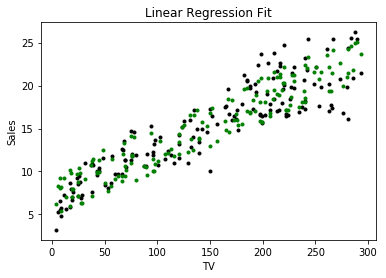

In [22]:
# 线性回归建模效果图（这个图有问题，可取消展示）
plt.plot(X_train_one,y_train, 'k.')
plt.title('Linear Regression Fit')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.plot(X_train_one,y_train_hat , 'g.')
plt.show()

# 11.4验证

一、模型拟合效果评估

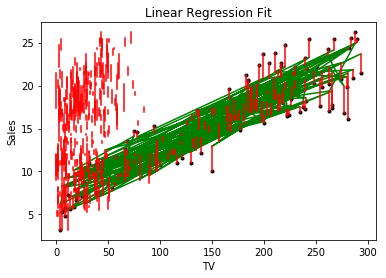

In [23]:
# 线性回归残差分析（这个图也有前一个图同样的问题，取消展示）
plt.plot(X_train[:,0],y_train, 'k.')
plt.title('Linear Regression Fit')
plt.xlabel('TV')
plt.ylabel('Sales')
plt.plot(X_train[:,0],y_train_hat , 'g-')

# 残差预测值
for i, x in enumerate(X_train):#  enumerate 函数可以把一个 list 变成索引-元素对
    plt.plot([x, x], [y_train[i], y_train_hat[i]], 'r-')
plt.show()

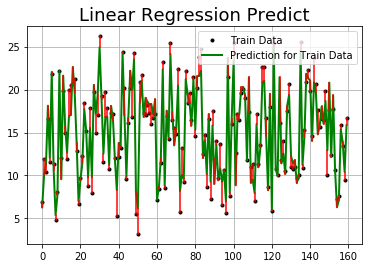

In [24]:
plt.figure(facecolor='w')
t = np.arange(len(X_train[:,0]))
plt.plot(t, y_train, 'k.', linewidth=2, label=u'Train Data')
plt.plot(t, y_train_hat, 'g-', linewidth=2, label=u'Prediction for Train Data')

# 残差预测值
for i, x in enumerate(t):#  enumerate 函数可以把一个 list 变成索引-元素对
    plt.plot([x,x], [y_train[i], y_train_hat[i]], 'r-')

plt.legend(loc='upper right')
plt.title(u'Linear Regression Predict', fontsize=18)
plt.grid(b=True)
plt.show()

我们可以通过残差之和最小化实现最佳拟合，也就是说模型预测的值与训练集的数据最接近就是最佳拟合。对模型的拟合度进行评估的函数称为残差平方和（residual sum of squares）成本函数。就是
让所有训练数据与模型的残差的平方之和最小化，如下所示：
……
其中，yi 是观测值，f(xi) 是预测值。

In [25]:
# 计算残差平方和
import numpy as np
print('残差平方和:{:.2f}'.format(np.mean((y_train_hat - y_train) ** 2)))

残差平方和:2.40


R²是指拟合优度（判决系数），是回归直线对观测值的拟合程度。R²等于回归平方和在总平方和中所占的比率，即回归方程所能解释的因变量变异性的百分比。R²最大值为1。R²的值越接近1，说明回归直线对观测值的拟合程度越好；反之，R²的值越小，说明回归直线对观测值的拟合程度越差。


列出R方的取值列表

R2=SSR/SST=1-SSE/SST

其中：SST=SSR+SSE，SST(total sum of squares)为总平方bai和，SSR(regression sum of squares)为回归平方和，SSE(error sum of squares) 为残差平方和。

In [26]:
# 计算残差平方和
print('残差平方和:{:.2f}'.format(np.mean((y_train_hat - y_train) ** 2)))
# 计算R方
print('判决系数:{:.2f}'.format(model.score(X_train, y_train)))

残差平方和:2.40
判决系数:0.91


二、模型预测

预测残差平方和较低，判决系数R方为0.86，说明回归直线对观测值有很好的拟合程度

In [27]:
y_test_hat=model.predict(X_test)

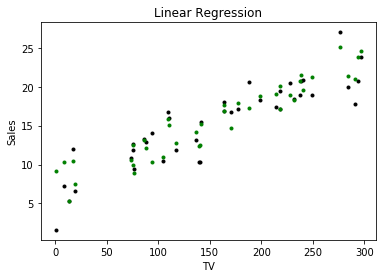

In [28]:
# 线性回归预测效果图（取消展示）
plt.plot(X_test[:,0],y_test, 'k.')
plt.title('Linear Regression')
plt.xlabel('TV')
plt.ylabel('Sales')

plt.plot(X_test[:,0],y_test_hat , 'g.')
plt.show()

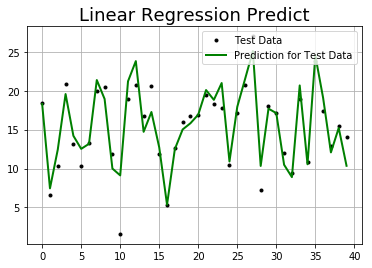

In [29]:
# 可视化模型对测试集的预测能力
plt.figure()
t = np.arange(len(X_test[:,0]))
plt.plot(t, y_test, 'k.', linewidth=2, label=u'Test Data')
plt.plot(t, y_test_hat, 'g-', linewidth=2, label=u'Prediction for Test Data')
plt.legend(loc='upper right')
plt.title(u'Linear Regression Predict', fontsize=18)
plt.grid()
plt.show()

In [30]:
# 计算残差平方和
print('残差平方和:{:.2f}'.format(np.mean((y_test_hat -y_test) ** 2)))
# 计算R方
print('判决系数:{:.2f}'.format(model.score(X_test, y_test)))

残差平方和:3.98
判决系数:0.85


模型的对'TV','Radio','Newspaper'的回归系数分别为0.0551，0.1002，0.0003，说明Radio的广告支出对销售额的影响最大，TV次之。这意味着每增加一单位的Radio广告支出，可带来10%的销售额提升。

In [31]:
print(model.intercept_) # 截距
print(model.coef_) #系数

4.6956704711911605
[ 0.0545854   0.11158486 -0.00390938]


模型可表示为Sales=0.551\*TV+0.1002\*Radio+0.003\*Newspaper+u

In [ ]:
# 线性回归残差图
plt.plot(y_train,(y_train_hat - y_train) ** 2, 'k.')
plt.title('Linear Regression Error')
plt.xlabel('y')
plt.ylabel('error square')
plt.show()

In [ ]:
# 线性回归建模效果图（这个图有问题，可取消展示）
plt.plot(y_train,(y_train_hat_one - y_train) ** 2, 'k.')
plt.title('Linear Regression Fit')
plt.xlabel('TV')
plt.ylabel('Sales')
# plt.plot(X_train_one,y_train_hat , 'g.')
plt.show()